### Predict the price of the Uber ride from a given pickup point to the agreed drop-off
### location. Perform following tasks:
### 1. Pre-process the dataset.
### 2. Identify outliers.
### 3. Check the correlation.
### 4. Implement linear regression and ridge, Lasso regression models.
### 5. Evaluate the models and compare their respective scores like R2, RMSE, etc.
#### Dataset link: https://www.kaggle.com/datasets/yasserh/uber-fares-dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yasserh/uber-fares-dataset")

# Load dataset
df = pd.read_csv(f"{path}/uber.csv")
df.head()

100%|██████████| 7.04M/7.04M [00:00<00:00, 37.9MB/s]

Extracting files...


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [3]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


,0
Unnamed: 0,0
key,0
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,1
dropoff_latitude,1
passenger_count,0


In [4]:
df = df.dropna()

In [5]:
df = df[(df['fare_amount'] > 0) &
        (df['passenger_count'] > 0) & (df['passenger_count'] <= 6) &
        (df['pickup_latitude'].between(-90, 90)) &
        (df['dropoff_latitude'].between(-90, 90)) &
        (df['pickup_longitude'].between(-180, 180)) &
        (df['dropoff_longitude'].between(-180, 180))]

## Extract Time Features from pickup_datetime

In [6]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
df = df.dropna(subset=['pickup_datetime'])

df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['day'] = df['pickup_datetime'].dt.day
df['hour'] = df['pickup_datetime'].dt.hour

In [7]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,19
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,20
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,21
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,26,8
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,28,17


### IDentify Outliers

### We can use boxplots to visualize and remove outliers.

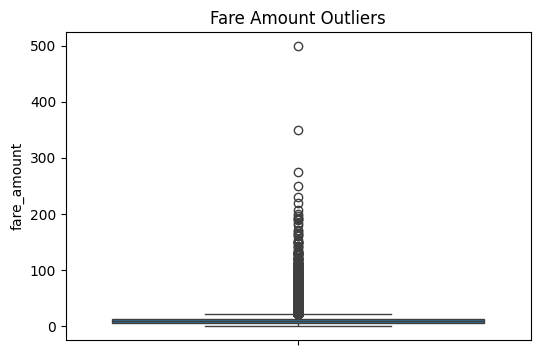

In [8]:
plt.figure(figsize=(6,4))
sns.boxplot(df['fare_amount'])
plt.title('Fare Amount Outliers')
plt.show()

In [9]:
df = df[df['fare_amount'] < 10]

In [10]:
df.shape

(121476, 13)

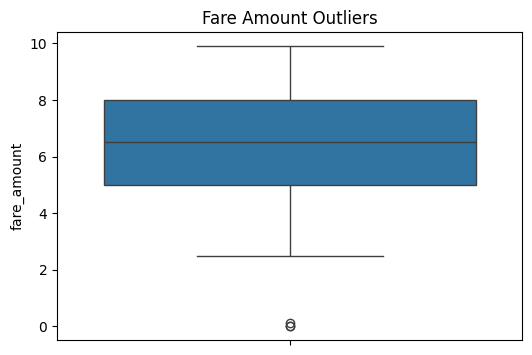

In [11]:
plt.figure(figsize=(6,4))
sns.boxplot(df['fare_amount'])
plt.title('Fare Amount Outliers')
plt.show()

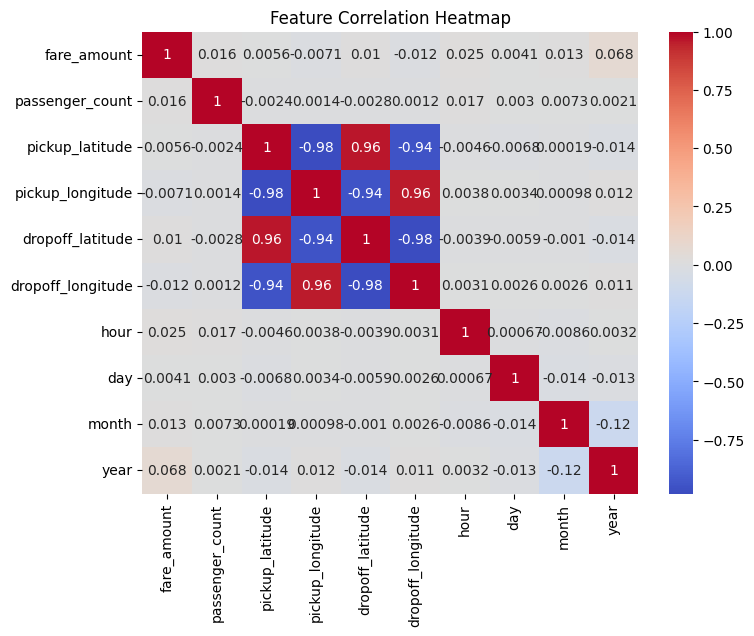

In [12]:
corr = df[['fare_amount', 'passenger_count', 'pickup_latitude', 'pickup_longitude',
           'dropoff_latitude', 'dropoff_longitude', 'hour', 'day', 'month', 'year']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

### Feature Selection and Train-Test Split

In [13]:
X = df[['passenger_count', 'pickup_longitude', 'pickup_latitude',
        'dropoff_longitude', 'dropoff_latitude', 'hour', 'day', 'month', 'year']]
y = df['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


##Model Implementation
###Linear Regression

In [14]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred_lin = lin_reg.predict(X_test)


### Ridge Regression

In [15]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

y_pred_ridge = ridge.predict(X_test)

Lasso Regression

In [16]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

y_pred_lasso = lasso.predict(X_test)

### Model Evaluation

In [17]:
def evaluate_model(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{model_name}: R2 = {r2:.4f}, RMSE = {rmse:.4f}")

In [18]:
evaluate_model(y_test, y_pred_lin, "Linear Regression")
evaluate_model(y_test, y_pred_ridge, "Ridge Regression")
evaluate_model(y_test, y_pred_lasso, "Lasso Regression")

Linear Regression: R2 = 0.0058, RMSE = 1.7496
Ridge Regression: R2 = 0.0058, RMSE = 1.7496
Lasso Regression: R2 = 0.0040, RMSE = 1.7512
